### 가우시안 노이즈 추가

In [27]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

import sys
sys.path.append('../../tool_code/python_tool_code/frequency_dataset_generation/')
from FFT_func import FFT

# 시드 설정 - 동일한 시뮬레이션 결과를 위해 설정
# 1000_data: seed = 10
# 2000_data: seed = 20
# 10000_data: seed = 100 
np.random.seed(100)

# Set some general settings, to be used across all simulations
num_signals = 1000
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

# fpath = "C:/Users/stell/OneDrive/바탕 화면/10000_data/"
fpath = 'C:/Users/User/Desktop/SCH/10000_data/'
Clean = np.load(fpath + 'clean_data.npy')
Clean = Clean[:1000]

In [28]:
# Generate artifact
frequency = 125
period = 1 / frequency
num_waveforms = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

asymmetric_artifact = np.zeros((0, len(times)))  # (0, 4000)
artifact = np.zeros((num_signals, len(times)))  # (0, 4000)

Artifact = np.zeros((0, len(times)))  # (0, 4000)

print(num_waveforms)
print(samples_per_period)

250
17


In [29]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    asymmetric_artifact = np.append(asymmetric_artifact, [osc_shape], axis=0)

print("Clean shape:", Clean.shape)  # (100, 4000)

# 음의 값이 2배가 되도록 y축 shifting
asymmetric_artifact = asymmetric_artifact * 1.75 - 0.75

print("Artifact shape:", asymmetric_artifact.shape)  # (N, 4000)

Clean shape: (1000, 4000)
Artifact shape: (1000, 4000)


In [30]:
# Apply artifacts and store in Artifact array
for i in range(num_signals):
    x = np.min(Clean[i, :]) * 10 / np.min(asymmetric_artifact[i, :])
    artifact_x10 = asymmetric_artifact[i, :] * x

    Artifact = np.append(Artifact, [artifact_x10], axis=0)

In [31]:
mean = 0
std = 1
gaussian_noise = np.random.normal(mean, std, asymmetric_artifact.shape)

Contaminated_by_A_GN = Artifact + Clean + gaussian_noise
Contaminated_by_GN = Clean + gaussian_noise

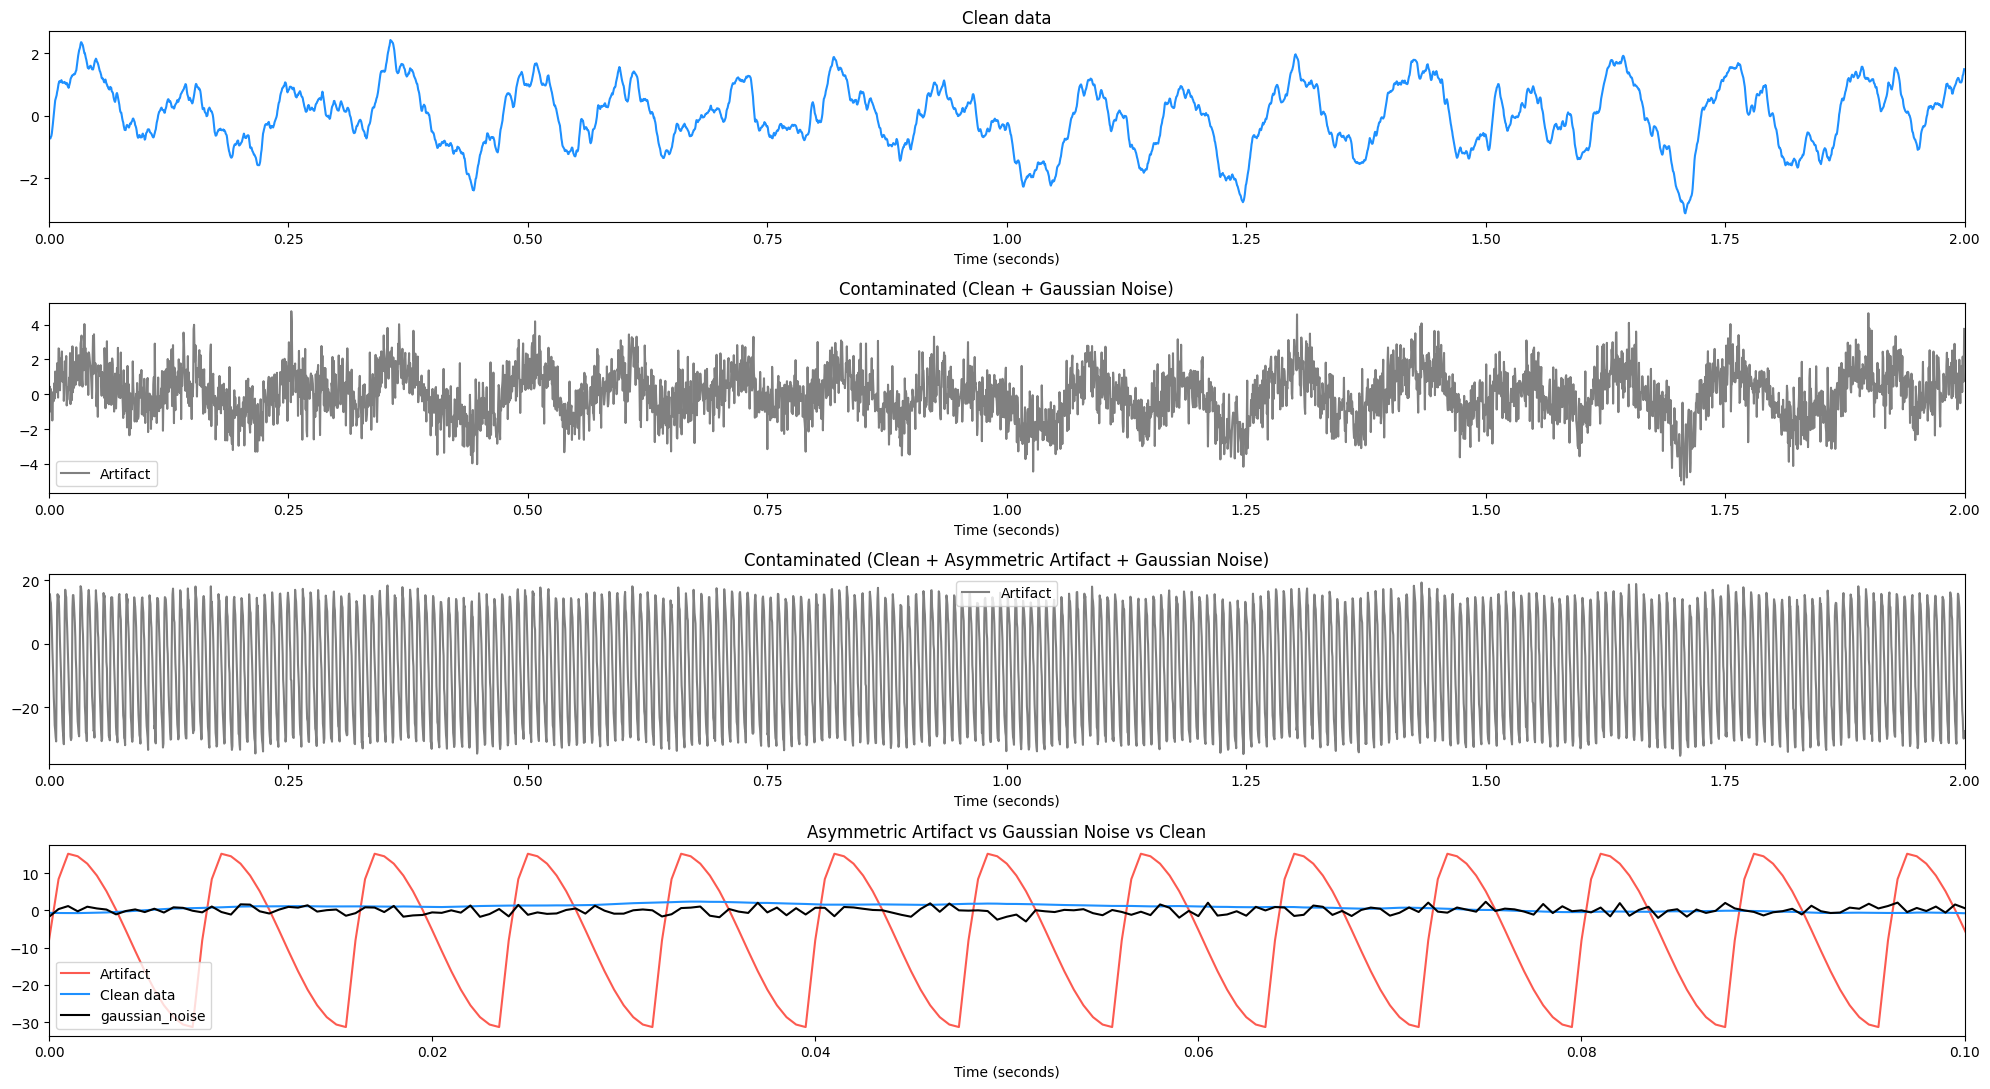

In [32]:
plt.figure(figsize=(20, 11))

num_sample = 0

plt.subplot(4, 1, 1)
plt.plot(times, Clean[num_sample, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('Clean data')

plt.subplot(4, 1, 2)
plt.plot(times, Contaminated_by_GN[num_sample, :], c='gray', label = 'Artifact')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Contaminated (Clean + Gaussian Noise)')
plt.xlim([0, 2])

plt.subplot(4, 1, 3)
plt.plot(times, Contaminated_by_A_GN[num_sample, :], c='gray', label = 'Artifact')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Contaminated (Clean + Asymmetric Artifact + Gaussian Noise)')
plt.xlim([0, 2])

plt.subplot(4, 1, 4)
plt.plot(times, Artifact[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.plot(times, Clean[num_sample, :], c='dodgerblue', label = 'Clean data')
plt.plot(times, gaussian_noise[num_sample, :], c='k', label = 'gaussian_noise')
plt.xlim([0, 0.1])
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Asymmetric Artifact vs Gaussian Noise vs Clean')

plt.tight_layout()
plt.show()


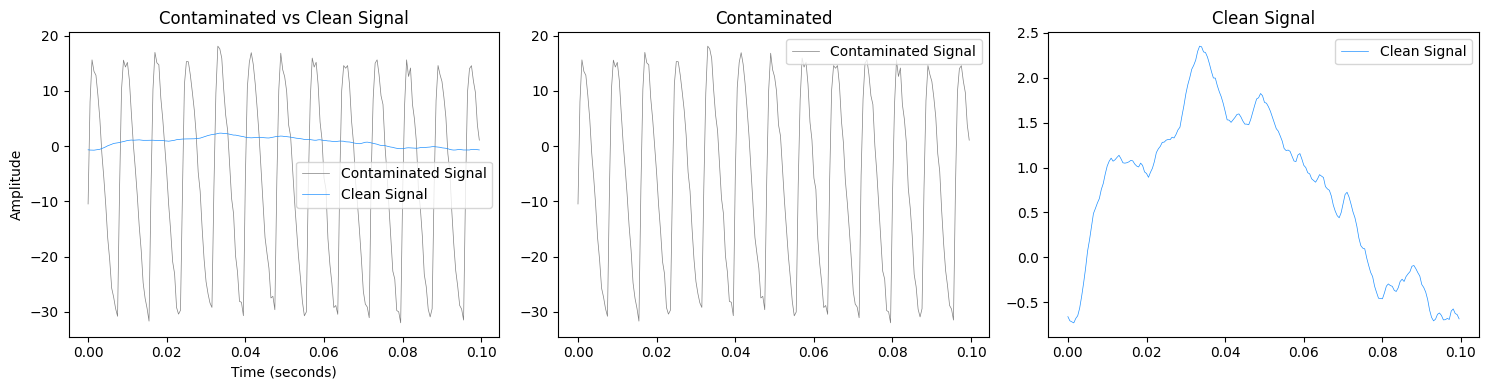

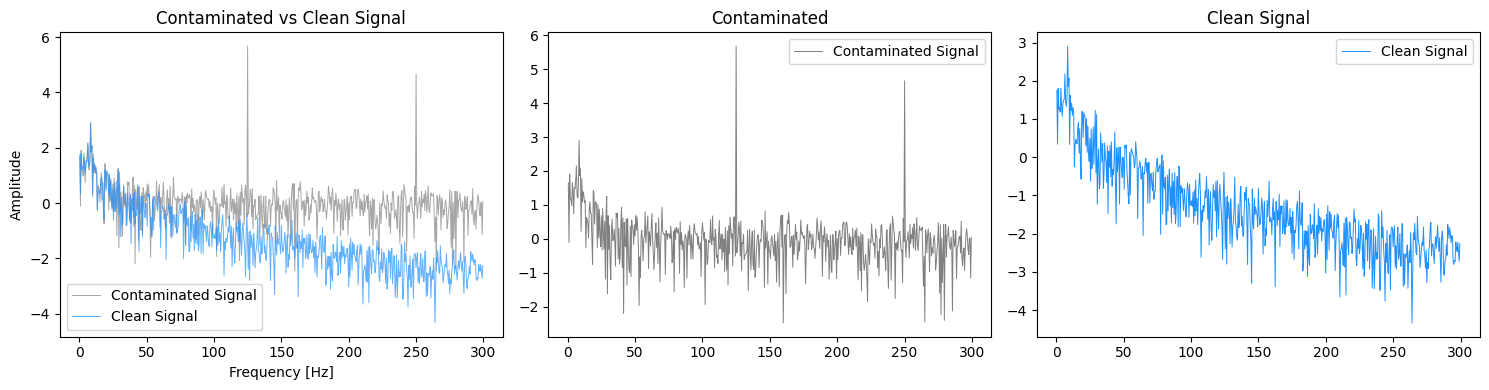

In [42]:
t = np.linspace(0, 2, num=fs*2) 

start_time = 0; # [sec]
end_time = 0.1; # [sec]
start_pts = int(start_time*fs)
end_pts = int(end_time*fs)

## Time domain Plotting ###
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(t[start_pts:end_pts], Contaminated_by_A_GN[0][start_pts:end_pts], label='Contaminated Signal', color='gray', alpha=1, linewidth=0.5)
plt.plot(t[start_pts:end_pts], Clean[0][start_pts:end_pts], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.5)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude')
plt.title('Contaminated vs Clean Signal');plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t[start_pts:end_pts], Contaminated_by_A_GN[0][start_pts:end_pts], label='Contaminated Signal', color='gray', alpha=1, linewidth=0.5)
plt.title('Contaminated');plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t[start_pts:end_pts], Clean[0][start_pts:end_pts], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.5)
plt.title('Clean Signal');plt.legend()
plt.tight_layout()
plt.show()

## Frequency domain Plottig ###  
freqs, _, _, Contaminated_psd = FFT(Contaminated_by_A_GN, fs, single_sided=True)
_, _, _, Clean_psd = FFT(Clean, fs, single_sided=True)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(freqs[1:600], np.log10(Contaminated_psd[0][1:600]), label='Contaminated Signal', color='gray', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(Clean_psd[0][1:600]), label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude')
plt.title('Contaminated vs Clean Signal');plt.legend()

plt.subplot(1, 3, 2)
plt.plot(freqs[1:600], np.log10(Contaminated_psd[0][1:600]), label='Contaminated Signal', color='gray', alpha=1, linewidth=0.7)
plt.title('Contaminated');plt.legend()

plt.subplot(1, 3, 3)
plt.plot(freqs[1:600], np.log10(Clean_psd[0][1:600]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.title('Clean Signal');plt.legend()
plt.tight_layout()
plt.show()

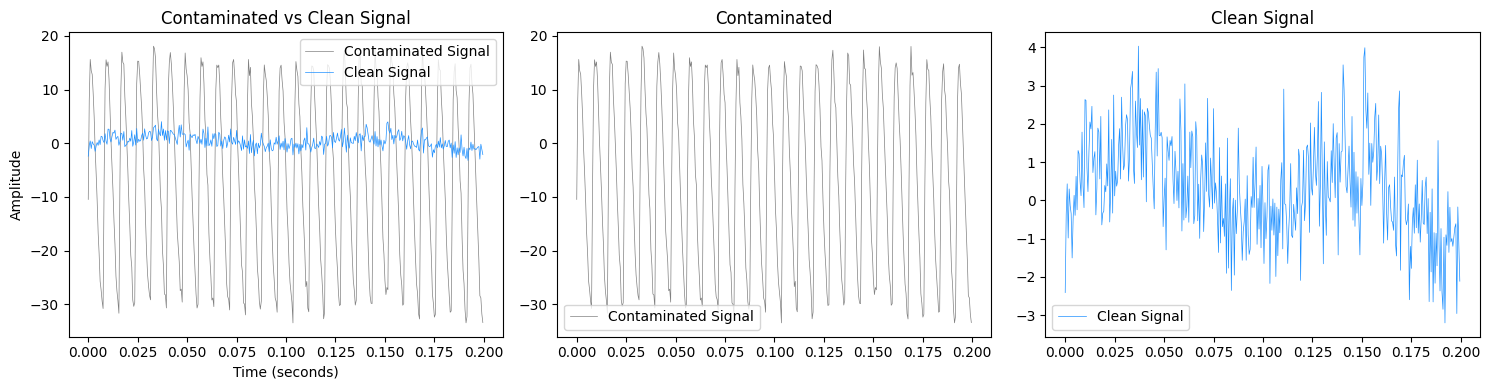

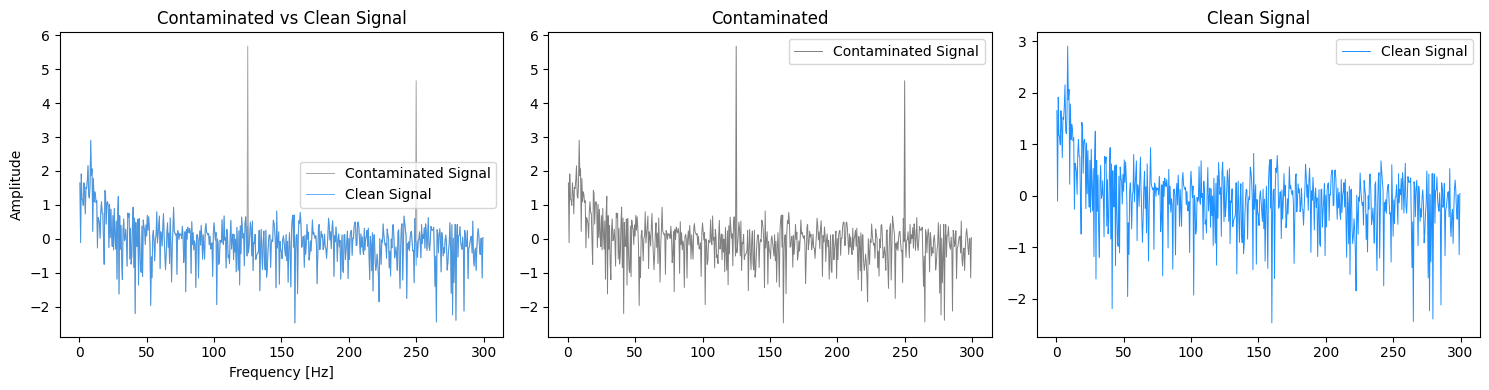

In [40]:
t = np.linspace(0, 2, num=fs*2)

start_time = 0; # [sec]
end_time = 0.2; # [sec]
start_pts = int(start_time*fs)
end_pts = int(end_time*fs)

## Time domain Plotting ###
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(t[start_pts:end_pts], Contaminated_by_A_GN[0][start_pts:end_pts], label='Contaminated Signal', color='gray', alpha=1, linewidth=0.5)
plt.plot(t[start_pts:end_pts], Contaminated_by_GN[0][start_pts:end_pts], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.5)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude')
plt.title('Contaminated vs Clean Signal');plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t[start_pts:end_pts], Contaminated_by_A_GN[0][start_pts:end_pts], label='Contaminated Signal', color='gray', alpha=1, linewidth=0.5)
plt.title('Contaminated');plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t[start_pts:end_pts], Contaminated_by_GN[0][start_pts:end_pts], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.5)
plt.title('Clean Signal');plt.legend()
plt.tight_layout()
plt.show()

## Frequency domain Plottig ###  
freqs, _, _, Contaminated_psd = FFT(Contaminated_by_A_GN, fs, single_sided=True)
_, _, _, Contaminated_by_GN_psd = FFT(Contaminated_by_GN, fs, single_sided=True)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(freqs[1:600], np.log10(Contaminated_psd[0][1:600]), label='Contaminated Signal', color='gray', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(Contaminated_by_GN_psd[0][1:600]), label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude')
plt.title('Contaminated vs Clean Signal');plt.legend()

plt.subplot(1, 3, 2)
plt.plot(freqs[1:600], np.log10(Contaminated_psd[0][1:600]), label='Contaminated Signal', color='gray', alpha=1, linewidth=0.7)
plt.title('Contaminated');plt.legend()

plt.subplot(1, 3, 3)
plt.plot(freqs[1:600], np.log10(Contaminated_by_GN_psd[0][1:600]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.title('Clean Signal');plt.legend()
plt.tight_layout()
plt.show()

In [34]:
# -------- < 저장 > ------------------------------------------------
# -------- < data > ------------------------------------------------

# np.save(fpath + "increment_artifact_data" + ".npy", Artifact_noisy)
